In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import Pie
from pyecharts.charts import Line

from snownlp import SnowNLP  # 情感分析

import re
import jieba
from itertools import chain  # 二维，一维列表转换
from collections import Counter
from wordcloud import WordCloud

In [3]:

file_path = r"/Users/pengyitong/Documents/大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析/数据/xiaomi.csv"
df = pd.read_csv(file_path)
df

,用户名,内容,点赞量,日期
0,SupremeWow,小米su7强势破圈太火爆了，雷总得抓紧提高产能啊,3025,2024-03-30 12:22:53
1,及米侠,感觉这次黑稿不太多，看来车圈还是更干净一些！,1725,2024-03-30 12:23:26
2,小麦Elite,小米手机1代回忆～,1020,2024-03-30 12:22:38
3,米12U,雷总辛苦了 感谢您为大家做了一辆Dream car,660,2024-03-30 12:22:39
4,Spider_boy666,雷总加电,650,2024-03-30 12:23:00
...,...,...,...,...
4568,春夏秋冬湖,欢迎雷军🍉,0,2024-05-18 19:58:08
4569,四季的暖窝,雷总，能不能发售ARE U OK大字母 运动包 能不能开MI家HOTEL，用SU7接送客人到MI家,0,2024-05-18 19:48:31
4570,米粉玩车局,中国平安的平安车险，未经本人允许，滥用本人姓名、电话、身份证信息，连续一个月车险客服电话骚扰...,0,2024-05-18 17:45:00
4571,浦东机场上空的轰鸣,不想体验你们的最新科技，雷嗨,0,2024-05-18 17:42:53


In [4]:
# 计算每一行中包含空值的数量
null_counts= df['内容'].isnull().sum()
null_counts

np.int64(465)

In [5]:
# 删除 '内容' 列中包含空值的所有行
df = df.dropna()

# 删除重复
df = df.drop_duplicates()
df.shape

(3591, 4)

In [7]:
#定义停用词列表
stopwords_file = '/Users/pengyitong/Documents/大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析/数据/stopwords_cn.txt'
stopwords=[]

#读取停用词文件并添加到停用词列表
with open(stopwords_file,'r', encoding='utf-8') as f:
    for line in f: # 遍历文件中的每一行
        stopwords.append(line.strip())

#分词处理函数，包括去除停用词和标点符号
def tokenize(text):
    if not isinstance(text, str):
        return np.nan # 这行代码检查输入的文本是否是字符串类型
    words = jieba.cut(text)
    filtered_words = [word for word in words if word not in stopwords and word.strip()] # 那些不在停用词列表中且不为空白字符的词语才会被保留
    filtered_text = '/'.join(filtered_words) #分词之间用斜杠分隔
    filtered_text_no_punctuation = re.sub(r'[^\w\s]','', filtered_text)
    filtered_text_no_extra_punctuation = re.sub(r'[\s+\.\!\/_,$%^*(+\"\')]+|[+——()?【】“”！，。？、~@#￥%……&*（）《》：]+', '', text)
    return filtered_text_no_extra_punctuation.split('/') #返回分词后的列表形式，词之间用斜杠分隔
    return filtered_text


df['内容'] = df['内容'].apply(lambda x: str(x) if pd.notnull(x) else '')
# 这一行代码的作用是确保review列中的每个值都被转换为字符串类型，并处理可能存在的缺失值（NaN）

# 对每一行文本进行分词处理，使用 apply 函数
df['tokenized_text'] = df['内容'].apply(tokenize)

df.head()

,用户名,内容,点赞量,日期,tokenized_text
0,SupremeWow,小米su7强势破圈太火爆了，雷总得抓紧提高产能啊,3025,2024-03-30 12:22:53,[小米su7强势破圈太火爆了雷总得抓紧提高产能啊]
1,及米侠,感觉这次黑稿不太多，看来车圈还是更干净一些！,1725,2024-03-30 12:23:26,[感觉这次黑稿不太多看来车圈还是更干净一些]
2,小麦Elite,小米手机1代回忆～,1020,2024-03-30 12:22:38,[小米手机1代回忆～]
3,米12U,雷总辛苦了 感谢您为大家做了一辆Dream car,660,2024-03-30 12:22:39,[雷总辛苦了感谢您为大家做了一辆Dreamcar]
4,Spider_boy666,雷总加电,650,2024-03-30 12:23:00,[雷总加电]


In [8]:
# 对每条评论进行分析
df['tokenized_text'] = df['tokenized_text'].astype(str)

df['word'] = df['tokenized_text'].map(lambda c: ' '.join(jieba.cut(c)))
df.head()

,用户名,内容,点赞量,日期,tokenized_text,word
0,SupremeWow,小米su7强势破圈太火爆了，雷总得抓紧提高产能啊,3025,2024-03-30 12:22:53,['小米su7强势破圈太火爆了雷总得抓紧提高产能啊'],[ ' 小米 su7 强势 破圈 太 火爆 了 雷 总得 抓紧 提高 产能 啊 ' ]
1,及米侠,感觉这次黑稿不太多，看来车圈还是更干净一些！,1725,2024-03-30 12:23:26,['感觉这次黑稿不太多看来车圈还是更干净一些'],[ ' 感觉 这次 黑稿 不太多 看来 车圈 还是 更 干净 一些 ' ]
2,小麦Elite,小米手机1代回忆～,1020,2024-03-30 12:22:38,['小米手机1代回忆～'],[ ' 小米 手机 1 代 回忆 ～ ' ]
3,米12U,雷总辛苦了 感谢您为大家做了一辆Dream car,660,2024-03-30 12:22:39,['雷总辛苦了感谢您为大家做了一辆Dreamcar'],[ ' 雷总 辛苦 了 感谢您 为 大家 做 了 一辆 Dreamcar ' ]
4,Spider_boy666,雷总加电,650,2024-03-30 12:23:00,['雷总加电'],[ ' 雷总加 电 ' ]


In [9]:

# 1).分词处理
def cut_word(text):
    return jieba.cut(text)

df['Word'] = df['word'].apply(cut_word)
df.sample(5)

,用户名,内容,点赞量,日期,tokenized_text,word,Word
86,揭阳大雨,泰裤辣！,1,2024-03-30 13:13:46,['泰裤辣'],[ ' 泰裤 辣 ' ],<generator object Tokenizer.cut at 0x32b2ac1a0>
2207,这是空白看不到看不到,对于智能门锁有个想法，现在智能门锁防猫眼设计不合理，要么需要按钮，但容易失灵，要么需要旋转按...,0,2024-04-13 16:34:01,['对于智能门锁有个想法现在智能门锁防猫眼设计不合理要么需要按钮但容易失灵要么需要旋转按钮打...,[ ' 对于 智能 门锁 有个 想法 现在 智能 门锁 防 猫眼 设计 不合理 要么 需要 ...,<generator object Tokenizer.cut at 0x32b35aae0>
565,漂在杭城,持续火爆,0,2024-05-21 11:31:00,['持续火爆'],[ ' 持续 火爆 ' ],<generator object Tokenizer.cut at 0x32b2e0880>
2516,imceciim,雷总 广东地区需要小米电动车,1,2024-04-10 15:40:13,['雷总广东地区需要小米电动车'],[ ' 雷总 广东地区 需要 小米 电动车 ' ],<generator object Tokenizer.cut at 0x32b371d20>
1823,团勤求创,雷总，能不能联合优秀车衣商，出一个Su7定制版的隐形车衣呀，这样就不会乱贴了。,0,2024-04-19 09:38:38,['雷总能不能联合优秀车衣商出一个Su7定制版的隐形车衣呀这样就不会乱贴了'],[ ' 雷 总能 不能 联合 优秀 车 衣商 出 一个 Su7 定制 版 的 隐形 车衣 呀...,<generator object Tokenizer.cut at 0x32b33dfe0>


In [10]:
df['Word']

0       <generator object Tokenizer.cut at 0x328eaa820>
1       <generator object Tokenizer.cut at 0x32b268f60>
2       <generator object Tokenizer.cut at 0x32b2690c0>
3       <generator object Tokenizer.cut at 0x32b269220>
4       <generator object Tokenizer.cut at 0x32b269380>
                             ...                       
4180    <generator object Tokenizer.cut at 0x32b3ecb40>
4182    <generator object Tokenizer.cut at 0x32b3ecca0>
4183    <generator object Tokenizer.cut at 0x32b3ece00>
4185    <generator object Tokenizer.cut at 0x32b3ecf60>
4187    <generator object Tokenizer.cut at 0x32b3ed0c0>
Name: Word, Length: 3591, dtype: object

In [12]:
# 2).删除停用词 

def get_stopword():
    s = set()
    with open(r"/Users/pengyitong/Documents/大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析/数据/stopwords_cn.txt", encoding="UTF-8") as f:
        for line in f:
            s.add(line.strip())
    return s

stopword = get_stopword()

def remove_stopword(words):
    return [word for word in words if word not in stopword]

df['Word'] = df['Word'].apply(remove_stopword)




df.head()

,用户名,内容,点赞量,日期,tokenized_text,word,Word
0,SupremeWow,小米su7强势破圈太火爆了，雷总得抓紧提高产能啊,3025,2024-03-30 12:22:53,['小米su7强势破圈太火爆了雷总得抓紧提高产能啊'],[ ' 小米 su7 强势 破圈 太 火爆 了 雷 总得 抓紧 提高 产能 啊 ' ],"[[, , ', , 小米, , su7, , 强势, , 破圈, , , 火..."
1,及米侠,感觉这次黑稿不太多，看来车圈还是更干净一些！,1725,2024-03-30 12:23:26,['感觉这次黑稿不太多看来车圈还是更干净一些'],[ ' 感觉 这次 黑稿 不太多 看来 车圈 还是 更 干净 一些 ' ],"[[, , ', , 感觉, , 这次, , 黑稿, , 不太多, , 看来, ..."
2,小麦Elite,小米手机1代回忆～,1020,2024-03-30 12:22:38,['小米手机1代回忆～'],[ ' 小米 手机 1 代 回忆 ～ ' ],"[[, , ', , 小米, , 手机, , 1, , 代, , 回忆, , ..."
3,米12U,雷总辛苦了 感谢您为大家做了一辆Dream car,660,2024-03-30 12:22:39,['雷总辛苦了感谢您为大家做了一辆Dreamcar'],[ ' 雷总 辛苦 了 感谢您 为 大家 做 了 一辆 Dreamcar ' ],"[[, , ', , 雷总, , 辛苦, , , 感谢您, , , , 做,..."
4,Spider_boy666,雷总加电,650,2024-03-30 12:23:00,['雷总加电'],[ ' 雷总加 电 ' ],"[[, , ', , 雷总加, , 电, , ', , ]]"


In [13]:
# list_2d = df['word'].tolist()

list_2d = df['Word'].tolist()
list_1d = list(chain.from_iterable(list_2d))
# 是一个二维列表 (2D list)，其每个元素都是一个列表

In [14]:
list_1d

['[',
 ' ',
 "'",
 ' ',
 '小米',
 ' ',
 'su7',
 ' ',
 '强势',
 ' ',
 '破圈',
 ' ',
 ' ',
 '火爆',
 ' ',
 ' ',
 '雷',
 ' ',
 '总得',
 ' ',
 '抓紧',
 ' ',
 '提高',
 ' ',
 '产能',
 ' ',
 ' ',
 "'",
 ' ',
 ']',
 '[',
 ' ',
 "'",
 ' ',
 '感觉',
 ' ',
 '这次',
 ' ',
 '黑稿',
 ' ',
 '不太多',
 ' ',
 '看来',
 ' ',
 '车圈',
 ' ',
 ' ',
 '更',
 ' ',
 '干净',
 ' ',
 ' ',
 "'",
 ' ',
 ']',
 '[',
 ' ',
 "'",
 ' ',
 '小米',
 ' ',
 '手机',
 ' ',
 '1',
 ' ',
 '代',
 ' ',
 '回忆',
 ' ',
 '～',
 ' ',
 "'",
 ' ',
 ']',
 '[',
 ' ',
 "'",
 ' ',
 '雷总',
 ' ',
 '辛苦',
 ' ',
 ' ',
 '感谢您',
 ' ',
 ' ',
 ' ',
 '做',
 ' ',
 ' ',
 '一辆',
 ' ',
 'Dreamcar',
 ' ',
 "'",
 ' ',
 ']',
 '[',
 ' ',
 "'",
 ' ',
 '雷总加',
 ' ',
 '电',
 ' ',
 "'",
 ' ',
 ']',
 '[',
 ' ',
 "'",
 ' ',
 ' ',
 '今天',
 ' ',
 ' ',
 ' ',
 ' ',
 '早上',
 ' ',
 '雷总',
 ' ',
 ' ',
 '发布会',
 ' ',
 '尤其',
 ' ',
 ' ',
 '汽车',
 ' ',
 '发布会',
 ' ',
 '最后',
 ' ',
 ' ',
 '鞠躬',
 ' ',
 ' ',
 ' ',
 '泪目',
 ' ',
 "'",
 ' ',
 ']',
 '[',
 ' ',
 "'",
 ' ',
 '相信',
 ' ',
 '总有一天',
 ' ',
 ' ',
 '全球',
 ' ',
 ' ',
 ' ',
 '一条',

In [15]:
df['word']


0       [ ' 小米 su7 强势 破圈 太 火爆 了 雷 总得 抓紧 提高 产能 啊 ' ]
1             [ ' 感觉 这次 黑稿 不太多 看来 车圈 还是 更 干净 一些 ' ]
2                            [ ' 小米 手机 1 代 回忆 ～ ' ]
3          [ ' 雷总 辛苦 了 感谢您 为 大家 做 了 一辆 Dreamcar ' ]
4                                     [ ' 雷总加 电 ' ]
                           ...                     
4180                            [ ' 红米 还 出 汽车 吗 ' ]
4182                        [ ' 小米 fold3 为啥 造 的 ' ]
4183                                    [ ' suv ' ]
4185                            [ ' 来 了 来 了 雷 总 ' ]
4187                                     [ ' 第一 ' ]
Name: word, Length: 3591, dtype: object

/var/folders/ln/vtlcjcd5303gxd313xg81ygw0000gn/T/ipykernel_30149/2272467999.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(d.keys()),y=list(d.values()), palette="Set2")


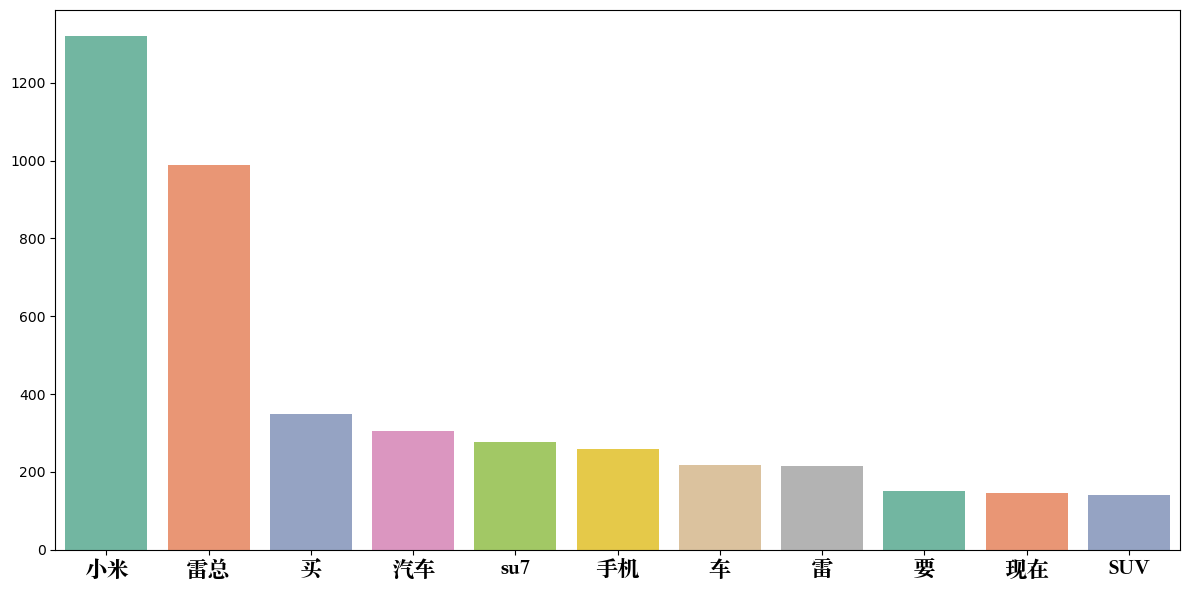

In [22]:
# 词频可视化  top15
c = Counter(list_1d)
common = c.most_common(15)

# 移除前四个最常见的结果
filtered_common = common[4:]

# 将词频结果转换为字典
d = dict(filtered_common)
# d = dict(common)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname='/System/Library/Fonts/Supplemental/Songti.ttc', size=16)

plt.figure(figsize=(12,6))
sns.barplot(x=list(d.keys()),y=list(d.values()), palette="Set2")
plt.xticks(fontproperties=myfont)

# 保存图表
output_path = r'/Users/pengyitong/Documents/大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析/可视化/MAC测试词频可视化.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [23]:
 list(d.values())

[1321, 989, 348, 306, 278, 258, 217, 214, 151, 145, 140]

/var/folders/ln/vtlcjcd5303gxd313xg81ygw0000gn/T/ipykernel_30149/3755576971.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(d.keys()), y=percentage, palette="Set3")


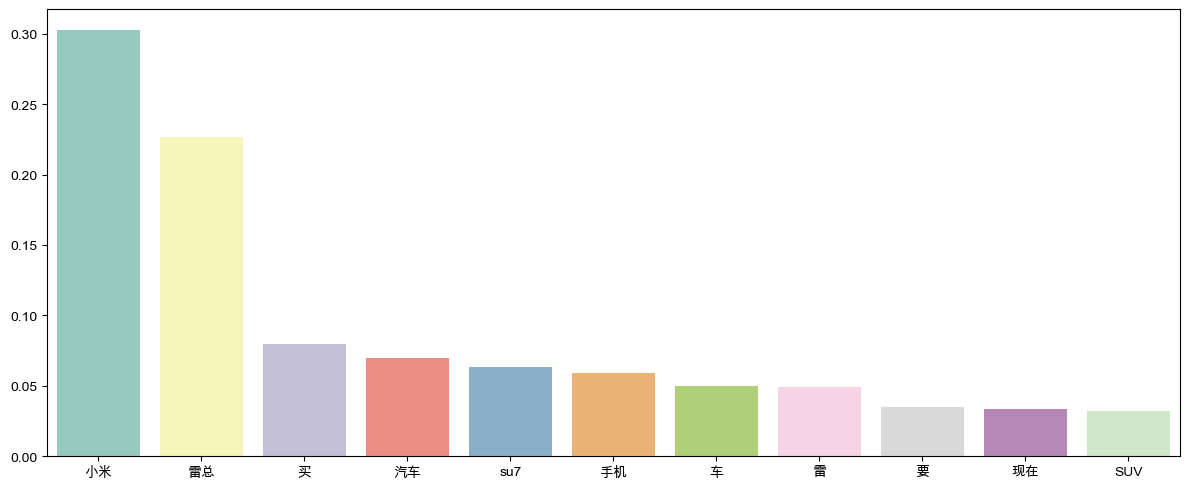

In [26]:
# 词频占比 top15
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
total = sum(d.values()) 
percentage = [v/ total for v in d.values()]
# print([f"{v:.2f}%" for v in percentage])
plt.figure(figsize=(12, 5))
sns.barplot(x=list(d.keys()), y=percentage, palette="Set3")

# 保存图表
output_path = r'/Users/pengyitong/Documents/大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析/可视化/MAC测试词频占比.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

/var/folders/ln/vtlcjcd5303gxd313xg81ygw0000gn/T/ipykernel_30149/1724843775.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counter.keys()), y=list(counter.values()), palette="Set2")


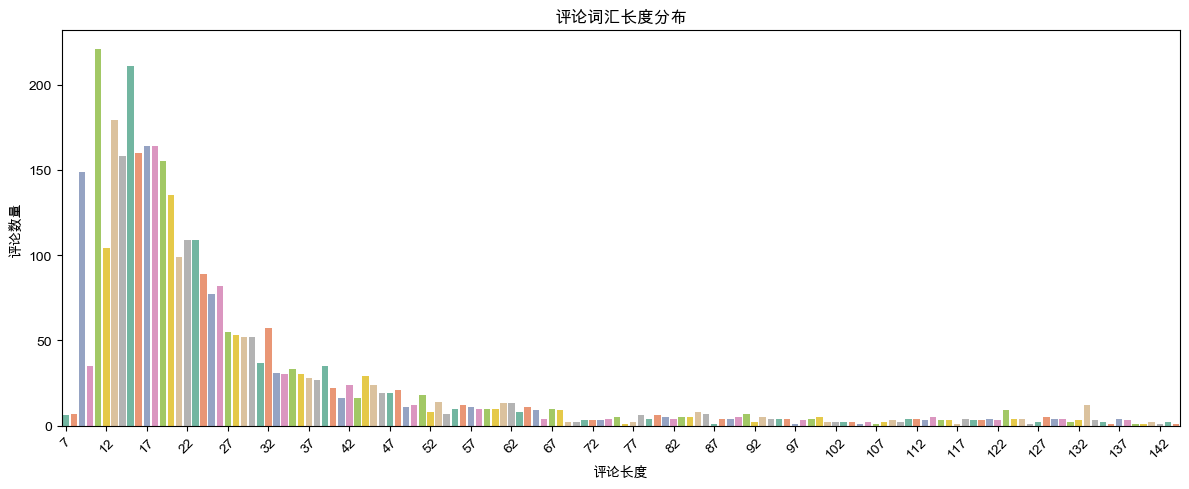

In [34]:
from collections import Counter

num = [len(li) for li in list_2d]
counter = Counter(num)
length = len(num)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(counter.keys()), y=list(counter.values()), palette="Set2")

plt.xlabel("评论长度")
plt.ylabel("评论数量")
plt.title("评论词汇长度分布")

plt.xticks(ticks=plt.xticks()[0][::5], rotation=45)  # 每隔 5 个刻度显示一次
# plt.xticks() 单独用的时候，其实返回的是一个 元组：(array([...]), [Text(...), Text(...), ...])

# 保存图表
output_path = r'/Users/pengyitong/Documents/大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析/可视化/MAC测试评论长度.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

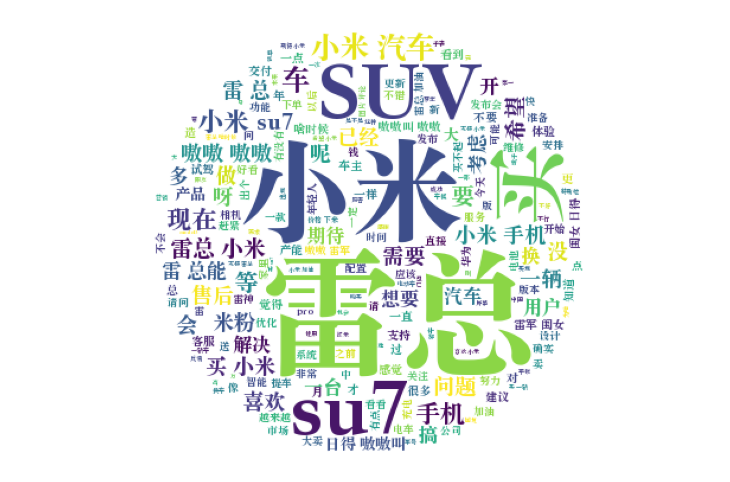

In [38]:
wc = WordCloud(font_path=r"/System/Library/Fonts/Supplemental/Songti.ttc",
               mask=plt.imread(r'圆.jpg'),
               background_color='white')

# wordcloud要求传递的词汇是用空格分开的字符串
join_words = ' '.join(list_1d)
img = wc.generate(join_words)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
wc.to_file(r"/Users/pengyitong/Documents/大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析/可视化/MAC测试小米评论词云.png")
plt.show()